In [1]:
import numpy as np
import pandas as pd

In [2]:
def binarize(df):
    for col in ['authorized_flag', 'category_1']:
        df[col] = df[col].map({'Y':1, 'N':0})
    return df

historical_transactions= pd.read_csv( 'historical_transactions.csv')
new_transactions= pd.read_csv( 'new_merchant_transactions.csv')
train= pd.read_csv('train.csv')
test= pd.read_csv('test.csv')
historical_transactions = binarize(historical_transactions)
new_transactions = binarize(new_transactions)

In [3]:
import datetime
train['first_active_month'] = pd.to_datetime(train['first_active_month'])
test['first_active_month'] = pd.to_datetime(test['first_active_month'])
train['elapsed_time'] = (datetime.date(2018, 2, 1) - train['first_active_month'].dt.date).dt.days
test['elapsed_time'] = (datetime.date(2018, 2, 1) - test['first_active_month'].dt.date).dt.days
target = train['target']
del train['target']

In [4]:
historical_transactions.purchase_date= pd.to_datetime(historical_transactions.purchase_date)
new_transactions.purchase_date= pd.to_datetime(new_transactions.purchase_date)
historical_transactions['month_diff'] = ((datetime.datetime.today() - historical_transactions['purchase_date']).dt.days)//30
historical_transactions['month_diff'] += historical_transactions['month_lag']
new_transactions['month_diff'] = ((datetime.datetime.today() - new_transactions['purchase_date']).dt.days)//30
new_transactions['month_diff'] += new_transactions['month_lag']

In [5]:
historical_transactions = pd.get_dummies(historical_transactions, columns=['category_2', 'category_3'])
new_transactions = pd.get_dummies(new_transactions, columns=['category_2', 'category_3'])
agg_fun = {'authorized_flag': ['mean']}
auth_mean = historical_transactions.groupby(['card_id']).agg(agg_fun)
auth_mean.columns = ['_'.join(col).strip() for col in auth_mean.columns.values]
auth_mean.reset_index(inplace=True)
authorized_transactions = historical_transactions[historical_transactions['authorized_flag'] == 1]
historical_transactions = historical_transactions[historical_transactions['authorized_flag'] == 0]

In [6]:
historical_transactions['purchase_month'] = historical_transactions['purchase_date'].dt.month
authorized_transactions['purchase_month'] = authorized_transactions['purchase_date'].dt.month
new_transactions['purchase_month'] = new_transactions['purchase_date'].dt.month

In [7]:
def aggregate_transactions(history):
    
    history.loc[:, 'purchase_date'] = pd.DatetimeIndex(history['purchase_date']).\
                                      astype(np.int64) * 1e-9
    
    agg_func = {
    'category_1': ['sum', 'mean'],
    'category_2_1.0': ['mean'],
    'category_2_2.0': ['mean'],
    'category_2_3.0': ['mean'],
    'category_2_4.0': ['mean'],
    'category_2_5.0': ['mean'],
    'category_3_A': ['mean'],
    'category_3_B': ['mean'],
    'category_3_C': ['mean'],
    'merchant_id': ['nunique'],
    'merchant_category_id': ['nunique'],
    'state_id': ['nunique'],
    'city_id': ['nunique'],
    'subsector_id': ['nunique'],
    'purchase_amount': ['sum', 'mean', 'max', 'min', 'std'],
    'installments': ['sum', 'mean', 'max', 'min', 'std'],
    'purchase_month': ['mean', 'max', 'min', 'std'],
    'purchase_date': [np.ptp, 'min', 'max'],
    'month_lag': ['mean', 'max', 'min', 'std'],
    'month_diff': ['mean']
    }
    
    agg_history = history.groupby(['card_id']).agg(agg_func)
    agg_history.columns = ['_'.join(col).strip() for col in agg_history.columns.values]
    agg_history.reset_index(inplace=True)
    
    df = (history.groupby('card_id')
          .size()
          .reset_index(name='transactions_count'))
    
    agg_history = pd.merge(df, agg_history, on='card_id', how='left')
    
    return agg_history

In [8]:
history = aggregate_transactions(historical_transactions)
history.columns = ['hist_' + c if c != 'card_id' else c for c in history.columns]

In [9]:
authorized = aggregate_transactions(authorized_transactions)
authorized.columns = ['auth_' + c if c != 'card_id' else c for c in authorized.columns]
new = aggregate_transactions(new_transactions)
new.columns = ['new_' + c if c != 'card_id' else c for c in new.columns]
def aggregate_per_month(history):
    grouped = history.groupby(['card_id', 'month_lag'])

    agg_func = {
            'purchase_amount': ['count', 'sum', 'mean', 'min', 'max', 'std'],
            'installments': ['count', 'sum', 'mean', 'min', 'max', 'std'],
            }

    intermediate_group = grouped.agg(agg_func)
    intermediate_group.columns = ['_'.join(col).strip() for col in intermediate_group.columns.values]
    intermediate_group.reset_index(inplace=True)

    final_group = intermediate_group.groupby('card_id').agg(['mean', 'std'])
    final_group.columns = ['_'.join(col).strip() for col in final_group.columns.values]
    final_group.reset_index(inplace=True)
    
    return final_group
final_group =  aggregate_per_month(authorized_transactions) 
final_group[:10]

,card_id,month_lag_mean,month_lag_std,purchase_amount_count_mean,purchase_amount_count_std,purchase_amount_sum_mean,purchase_amount_sum_std,purchase_amount_mean_mean,purchase_amount_mean_std,purchase_amount_min_mean,...,installments_sum_mean,installments_sum_std,installments_mean_mean,installments_mean_std,installments_min_mean,installments_min_std,installments_max_mean,installments_max_std,installments_std_mean,installments_std_std
0,C_ID_00007093c1,-6.000000,3.894440,8.769231,3.539158,-4.803314,2.175011,-0.536131,0.075418,-0.702649,...,11.307692,4.210792,1.369646,0.423190,1.000000,0.000000,2.538462,1.613246,0.625428,0.675607
1,C_ID_0001238066,-2.500000,1.870829,20.000000,11.696153,-11.776212,6.676914,-0.603215,0.046045,-0.730351,...,32.500000,24.501020,1.652873,0.410539,0.666667,0.816497,4.666667,2.875181,1.256525,0.521292
2,C_ID_0001506ef0,-6.230769,4.225988,4.769231,4.342692,-2.438161,2.902501,-0.446660,0.271125,-0.725724,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,C_ID_0001793786,-4.500000,3.027650,18.900000,12.160501,-2.496067,4.018810,-0.005687,0.271221,-0.646277,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,C_ID_000183fdda,-2.500000,1.870829,22.833333,7.167054,-11.316093,4.800612,-0.489227,0.141015,-0.728405,...,40.833333,14.048725,1.834943,0.362557,0.333333,1.032796,9.166667,2.041241,2.144389,0.665529
5,C_ID_00024e244b,-6.384615,4.330867,4.076923,4.290717,-2.557396,2.089708,-0.685118,0.071894,-0.728885,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,C_ID_0002709b5a,-5.000000,3.316625,6.090909,3.505839,-3.994622,2.440540,-0.638637,0.060836,-0.700104,...,10.727273,8.427229,1.965729,1.287108,0.818182,0.603023,3.818182,3.341203,1.600058,1.734256
7,C_ID_00027503e2,-4.000000,2.738613,2.666667,1.224745,-1.974976,0.909525,-0.740077,0.002424,-0.742206,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,C_ID_000298032a,-5.250000,4.334249,3.500000,1.772811,-1.844563,0.699127,-0.590214,0.168008,-0.686623,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,C_ID_0002ba3c2e,-4.666667,3.141125,9.166667,4.665476,-5.843052,3.021165,-0.638037,0.044976,-0.721448,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [10]:
def successive_aggregates(df, field1, field2):
    t = df.groupby(['card_id', field1])[field2].mean()
    u = pd.DataFrame(t).reset_index().groupby('card_id')[field2].agg(['mean', 'min', 'max', 'std'])
    u.columns = [field1 + '_' + field2 + '_' + col for col in u.columns.values]
    u.reset_index(inplace=True)
    return u
additional_fields = successive_aggregates(new_transactions, 'category_1', 'purchase_amount')
additional_fields = additional_fields.merge(successive_aggregates(new_transactions, 'installments', 'purchase_amount'),
                                            on = 'card_id', how='left')
additional_fields = additional_fields.merge(successive_aggregates(new_transactions, 'city_id', 'purchase_amount'),
                                            on = 'card_id', how='left')
additional_fields = additional_fields.merge(successive_aggregates(new_transactions, 'category_1', 'installments'),
                                            on = 'card_id', how='left')

In [34]:
train = pd.merge(train, history, on='card_id', how='left')
test = pd.merge(test, history, on='card_id', how='left')

train = pd.merge(train, authorized, on='card_id', how='left')
test = pd.merge(test, authorized, on='card_id', how='left')

train = pd.merge(train, new, on='card_id', how='left')
test = pd.merge(test, new, on='card_id', how='left')

train = pd.merge(train, final_group, on='card_id', how='left')
test = pd.merge(test, final_group, on='card_id', how='left')

train = pd.merge(train, auth_mean, on='card_id', how='left')
test = pd.merge(test, auth_mean, on='card_id', how='left')

train = pd.merge(train, additional_fields, on='card_id', how='left')
test = pd.merge(test, additional_fields, on='card_id', how='left')

In [35]:
unimportant_features = ['auth_category_2_1.0_mean','auth_category_2_2.0_mean','auth_category_2_3.0_mean',
    'auth_category_2_5.0_mean','hist_category_2_3.0_mean','hist_category_2_4.0_mean',
    'hist_category_2_5.0_mean', 'hist_category_3_A_mean','hist_installments_min',
    'hist_installments_std','hist_month_lag_std','hist_purchase_amount_max',
     'hist_purchase_month_max','hist_purchase_month_min','hist_purchase_month_std',
     'installments_min_mean','new_category_2_1.0_mean','new_category_2_2.0_mean',
     'new_category_2_3.0_mean','new_category_2_5.0_mean','new_city_id_nunique',
     'new_installments_std','new_state_id_nunique','purchase_amount_mean_mean']
features = [c for c in train.columns if c not in ['card_id', 'first_active_month']]
features = [f for f in features if f not in unimportant_features]
categorical_feats = ['feature_2', 'feature_3']

In [45]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
folds = KFold(n_splits=5, shuffle=True, random_state=15)
oof = np.zeros(len(train))
predictions_lgb = np.zeros(len(test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features],
                           label=target.iloc[trn_idx].clip(-25,20),
                           categorical_feature=categorical_feats
                          )
    val_data = lgb.Dataset(train.iloc[val_idx][features],
                           label=target.iloc[val_idx].clip(-25,20),
                           categorical_feature=categorical_feats
                          )

    num_round = 10000
    clf = lgb.train(param,
                    trn_data,
                    num_round,
                    valid_sets = [trn_data, val_data],
                    verbose_eval=100,
                    early_stopping_rounds = 300)
    
    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    predictions_lgb += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(mean_squared_error(oof, target)**0.5))

fold n°0


/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1194: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:753: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 300 rounds.
[100]	training's rmse: 2.99327	valid_1's rmse: 3.03402
[200]	training's rmse: 2.93446	valid_1's rmse: 2.99178
[300]	training's rmse: 2.89788	valid_1's rmse: 2.97095
[400]	training's rmse: 2.87134	valid_1's rmse: 2.9599
[500]	training's rmse: 2.85138	valid_1's rmse: 2.95341
[600]	training's rmse: 2.83473	valid_1's rmse: 2.94946
[700]	training's rmse: 2.82129	valid_1's rmse: 2.9468
[800]	training's rmse: 2.8094	valid_1's rmse: 2.94506
[900]	training's rmse: 2.79847	valid_1's rmse: 2.9438
[1000]	training's rmse: 2.78822	valid_1's rmse: 2.94261
[1100]	training's rmse: 2.77906	valid_1's rmse: 2.94178
[1200]	training's rmse: 2.76978	valid_1's rmse: 2.94121
[1300]	training's rmse: 2.761	valid_1's rmse: 2.94093
[1400]	training's rmse: 2.75219	valid_1's rmse: 2.94054
[1500]	training's rmse: 2.74323	valid_1's rmse: 2.94036
[1600]	training's rmse: 2.73512	valid_1's rmse: 2.94012
[1700]	training's rmse: 2.72703	valid_1's rmse: 2.94012


In [46]:
sub_df = pd.DataFrame({"card_id":test["card_id"].values})
sub_df["target"] = predictions_lgb
sub_df.to_csv("submission11.csv", index=False)

In [18]:
predictions_lgb #CV score: 3.65401 for 6 fold

array([-4.09658868, -0.35268342, -1.44298011, ...,  0.89673156,
       -4.89288533,  0.19621305])

In [26]:
print("CV score: {:<8.5f}".format(mean_squared_error(np.clip(oof,-15,5), target)**0.5))

CV score: 3.65532 


In [44]:
#oof.min(), oof.max(), target.nlargest(), target[ target>-30].nsmallest(),np.clip(target,-20,20).nsmallest()
#len(target[target>5]), len(target[ (target > -30) & (target <-5)])
pd.Series([2, -4, -1, 6, 3]).clip(-2,5)

0    2
1   -2
2   -1
3    5
4    3
dtype: int64

In [15]:
import time
from sklearn.preprocessing import scale
#from sklearn.manifold import TSNE
from MulticoreTSNE import MulticoreTSNE as TSNE
tsne = TSNE(n_jobs=6)
from sklearn.decomposition import PCA
pca= PCA( n_components= 20)
#tsne= TSNE( n_components= 3, perplexity= 30)

In [17]:
pca_his= pd.merge( auth_mean, history, on='card_id',how='left')
pca_his= pca_his.merge( authorized, on='card_id', how='left')
pca_his= pca_his.merge( final_group, on='card_id', how='left')
auth_ins= [ 'auth_installments_sum', 'auth_installments_mean',
 'auth_installments_max','auth_installments_min', 'auth_installments_std']
ins_to_drop=[]
for col in pca_his.columns.values:
    if 'insta' in col and col not in auth_ins: 
        ins_to_drop.append(col)
dates_to_drop= ['hist_purchase_date_ptp','hist_purchase_date_min','hist_purchase_date_max']
pca_his.drop( dates_to_drop+ins_to_drop+['card_id'], axis= 1, inplace= True)
pca_his.fillna( method= 'ffill', inplace= True)
pca_his= pca_his.values
pca_his= scale( pca_his)
print('Entering PCA decomposition')
start= time.time()
pca_result= pca.fit_transform( pca_his)
print('PCA complete after %.2f minutes'%((start - time.time())/60))
start= time.time()
tsne_result= tsne.fit_transform( pca_result)
print('TSNE complete after %.2f minutes'%((start - time.time())/60))

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:176: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


Entering PCA decomposition
PCA complete after -0.04 minutes


KeyboardInterrupt: 

In [49]:
auth_mean.shape, train.shape

((325540, 2), (201917, 163))

In [ ]:
tsne_frame= pd.DataFrame( {
    'card_id': auth_mean.card_id,
    'tsne_1': tsne_result[:,0],
    'tsne_2': tsne_result[:,1],
    'tsne_3': tsne_result[:,2]
})

In [ ]:
train= train.merge( tsne_frame, on='card_id', how='left')
test= test.merge( tsne_frame, on='card_id', how='left')

folds = KFold(n_splits=5, shuffle=True, random_state=15)
oof = np.zeros(len(train))
predictions_lgb = np.zeros(len(test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features],
                           label=target.iloc[trn_idx],
                           categorical_feature=categorical_feats
                          )
    val_data = lgb.Dataset(train.iloc[val_idx][features],
                           label=target.iloc[val_idx],
                           categorical_feature=categorical_feats
                          )

    num_round = 10000
    clf = lgb.train(param,
                    trn_data,
                    num_round,
                    valid_sets = [trn_data, val_data],
                    verbose_eval=100,
                    early_stopping_rounds = 300)
    
    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions_lgb += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(mean_squared_error(oof, target)**0.5))

In [16]:
type(time.time())

float

In [21]:
print('%.2f'%((start - time.time())/60))

-9.20


In [18]:
pca_result.shape

(325540, 20)

In [19]:
start

1549334928.883981

In [16]:
tsne

In [11]:
knn_his= pd.merge( auth_mean, history, on='card_id',how='left')
knn_his= knn_his.merge( authorized, on='card_id', how='left')
knn_his= knn_his.merge( final_group, on='card_id', how='left')

In [12]:
knn_his[:5]

,card_id,authorized_flag_mean,hist_transactions_count,hist_category_1_sum,hist_category_1_mean,hist_category_2_1.0_mean,hist_category_2_2.0_mean,hist_category_2_3.0_mean,hist_category_2_4.0_mean,hist_category_2_5.0_mean,...,installments_sum_mean,installments_sum_std,installments_mean_mean,installments_mean_std,installments_min_mean,installments_min_std,installments_max_mean,installments_max_std,installments_std_mean,installments_std_std
0,C_ID_00007093c1,0.765101,35.0,4.0,0.114286,0.000000,0.000000,0.885714,0.0,0.000000,...,11.307692,4.210792,1.369646,0.423190,1.000000,0.000000,2.538462,1.613246,0.625428,0.675607
1,C_ID_0001238066,0.975610,3.0,0.0,0.000000,0.333333,0.000000,0.000000,0.0,0.666667,...,32.500000,24.501020,1.652873,0.410539,0.666667,0.816497,4.666667,2.875181,1.256525,0.521292
2,C_ID_0001506ef0,0.939394,4.0,0.0,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,C_ID_0001793786,0.875000,27.0,2.0,0.074074,0.111111,0.296296,0.111111,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,C_ID_000183fdda,0.951389,7.0,0.0,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,...,40.833333,14.048725,1.834943,0.362557,0.333333,1.032796,9.166667,2.041241,2.144389,0.665529


In [13]:
auth_ins= [ 'auth_installments_sum', 'auth_installments_mean',
 'auth_installments_max','auth_installments_min', 'auth_installments_std']
ins_to_drop=[]
for col in knn_his.columns.values:
    if 'insta' in col and col not in auth_ins: 
        ins_to_drop.append(col)
#ins_to_drop

In [14]:
dates_to_drop= ['hist_purchase_date_ptp','hist_purchase_date_min','hist_purchase_date_max']

In [15]:
new_missing_card= set(auth_mean.card_id) - set(new.card_id)
missing_idx= knn_his.loc[ knn_his.card_id.isin(list(new_missing_card))].index.values
to_KNN_rows= knn_his.iloc[ missing_idx]
knn_his.drop( knn_his.index[ missing_idx], inplace= True)
knn_his.drop( dates_to_drop+ins_to_drop+['card_id'], axis= 1, inplace= True)
to_KNN_rows.drop( dates_to_drop+ins_to_drop+['card_id'], axis= 1, inplace= True)

/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [16]:
from sklearn.preprocessing import scale
knn_his.fillna( method= 'ffill', inplace= True)
to_KNN_rows.fillna( method= 'ffill', inplace= True)
knn_his= scale(knn_his.values)
to_KNN_rows= scale(to_KNN_rows.values)

/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3790: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:176: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:176: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


In [17]:
new.loc[ new.card_id.isin(list(new_missing_card))]

,card_id,new_transactions_count,new_category_1_sum,new_category_1_mean,new_category_2_1.0_mean,new_category_2_2.0_mean,new_category_2_3.0_mean,new_category_2_4.0_mean,new_category_2_5.0_mean,new_category_3_A_mean,...,new_purchase_month_min,new_purchase_month_std,new_purchase_date_ptp,new_purchase_date_min,new_purchase_date_max,new_month_lag_mean,new_month_lag_max,new_month_lag_min,new_month_lag_std,new_month_diff_mean


In [18]:
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm_notebook
neigh= NearestNeighbors( n_neighbors= 1, algorithm= 'ball_tree')
neigh.fit(knn_his) 
knn_idx= []
#for i in tqdm_notebook( missing_idx):
 #   knn_idx.append(neigh.kneighbors(knn_his[i].reshape(1,-1), 2, return_distance=False))

from multiprocessing import Pool

def f(x):
    return neigh.kneighbors(x.reshape(1,-1), 1, return_distance=False)

if __name__ == '__main__':
    with Pool(50) as p:
        knn_idx= p.map(f, to_KNN_rows)

In [22]:
knn_idx;

In [20]:
np.array(knn_idx).squeeze().max(),new_and_additional.shape

NameError: name 'new_and_additional' is not defined

In [23]:
new_and_additional= pd.merge( new, additional_fields, how='left', on= 'card_id')

cards_temp= auth_mean.drop( auth_mean.index[ missing_idx]).reset_index().card_id
neighbors_found= []
for i in tqdm_notebook(np.array(knn_idx).squeeze()):
    neighbors_found.append( cards_temp[ i])

In [269]:
knnized.shape

(31641, 55)

In [24]:
from multiprocessing import Pool

def f(x):
    return new_and_additional[ new_and_additional.card_id == x].index.values

if __name__ == '__main__':
    with Pool(50) as p:
        knn_new_idx= p.map(f, neighbors_found)

In [25]:
knnized= pd.merge( new, additional_fields, how='left', on= 'card_id').reindex( np.array(knn_new_idx).reshape(1,-1).squeeze())
knnized[:2]

,card_id,new_transactions_count,new_category_1_sum,new_category_1_mean,new_category_2_1.0_mean,new_category_2_2.0_mean,new_category_2_3.0_mean,new_category_2_4.0_mean,new_category_2_5.0_mean,new_category_3_A_mean,...,installments_purchase_amount_max,installments_purchase_amount_std,city_id_purchase_amount_mean,city_id_purchase_amount_min,city_id_purchase_amount_max,city_id_purchase_amount_std,category_1_installments_mean,category_1_installments_min,category_1_installments_max,category_1_installments_std
286101,C_ID_fca69660df,2,0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,-0.701828,NaN,-0.701828,-0.716855,-0.686802,0.021251,0.0,0.0,0.0,NaN
152222,C_ID_8678bd8950,4,0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,-0.587161,NaN,-0.587161,-0.587161,-0.587161,NaN,0.0,0.0,0.0,NaN


In [26]:
knnized.card_id= list(new_missing_card)
knnized[:2]

,card_id,new_transactions_count,new_category_1_sum,new_category_1_mean,new_category_2_1.0_mean,new_category_2_2.0_mean,new_category_2_3.0_mean,new_category_2_4.0_mean,new_category_2_5.0_mean,new_category_3_A_mean,...,installments_purchase_amount_max,installments_purchase_amount_std,city_id_purchase_amount_mean,city_id_purchase_amount_min,city_id_purchase_amount_max,city_id_purchase_amount_std,category_1_installments_mean,category_1_installments_min,category_1_installments_max,category_1_installments_std
286101,C_ID_c3971c0a58,2,0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,-0.701828,NaN,-0.701828,-0.716855,-0.686802,0.021251,0.0,0.0,0.0,NaN
152222,C_ID_5f883fe64d,4,0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,-0.587161,NaN,-0.587161,-0.587161,-0.587161,NaN,0.0,0.0,0.0,NaN


In [27]:
knnized_final= pd.concat( [new_and_additional,knnized],axis= 0)

In [325]:
knnized_final.shape,auth_mean.shape

((325540, 55), (325540, 2))

In [28]:
train = pd.merge(train, history, on='card_id', how='left')
test = pd.merge(test, history, on='card_id', how='left')

train = pd.merge(train, authorized, on='card_id', how='left')
test = pd.merge(test, authorized, on='card_id', how='left')

train = pd.merge(train, final_group, on='card_id', how='left')
test = pd.merge(test, final_group, on='card_id', how='left')

train = pd.merge(train, auth_mean, on='card_id', how='left')
test = pd.merge(test, auth_mean, on='card_id', how='left')

train = pd.merge(train, knnized_final, on='card_id', how='left')
test = pd.merge(test, knnized_final, on='card_id', how='left')

In [33]:
param = {'num_leaves': 111,
         'min_data_in_leaf': 149, 
         'objective':'regression',
         'max_depth': 9,
         'learning_rate': 0.005,
         "boosting": "gbdt",
         "feature_fraction": 0.7522,
         "bagging_freq": 1,
         "bagging_fraction": 0.7083 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2634,
         "random_state": 133,
         "verbosity": -1}
features = [c for c in train.columns if c not in ['card_id', 'first_active_month']]
categorical_feats= ['feature_2','feature_3']
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
folds = KFold(n_splits=5, shuffle=True, random_state=14)
oof = np.zeros(len(train))
predictions_lgb = np.zeros(len(test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features],
                           label=target.iloc[trn_idx],
                           categorical_feature=categorical_feats
                          )
    val_data = lgb.Dataset(train.iloc[val_idx][features],
                           label=target.iloc[val_idx],
                           categorical_feature=categorical_feats
                          )

    num_round = 10000
    clf = lgb.train(param,
                    trn_data,
                    num_round,
                    valid_sets = [trn_data, val_data],
                    verbose_eval=100,
                    early_stopping_rounds = 200)
    
    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions_lgb += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(mean_squared_error(oof, target)**0.5))

fold n°0


/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1194: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:753: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.71893	valid_1's rmse: 3.80633
[200]	training's rmse: 3.6535	valid_1's rmse: 3.76261
[300]	training's rmse: 3.61111	valid_1's rmse: 3.74069
[400]	training's rmse: 3.58061	valid_1's rmse: 3.72873
[500]	training's rmse: 3.55656	valid_1's rmse: 3.72218
[600]	training's rmse: 3.53705	valid_1's rmse: 3.71846
[700]	training's rmse: 3.52016	valid_1's rmse: 3.71646
[800]	training's rmse: 3.50523	valid_1's rmse: 3.71492
[900]	training's rmse: 3.49142	valid_1's rmse: 3.7138
[1000]	training's rmse: 3.4783	valid_1's rmse: 3.71303
[1100]	training's rmse: 3.46628	valid_1's rmse: 3.71227
[1200]	training's rmse: 3.45468	valid_1's rmse: 3.71168
[1300]	training's rmse: 3.44362	valid_1's rmse: 3.71152
[1400]	training's rmse: 3.43344	valid_1's rmse: 3.71141
[1500]	training's rmse: 3.42333	valid_1's rmse: 3.71098
[1600]	training's rmse: 3.4137	valid_1's rmse: 3.71088
[1700]	training's rmse: 3.40404	valid_1's rmse: 3.7109

In [ ]:
>>> X = [[0], [1], [2], [3]]
>>> y = [0, 0, 1, 1]
>>> from sklearn.neighbors import KNeighborsRegressor
>>> neigh = KNeighborsRegressor(n_neighbors=2)
>>> neigh.fit(X, y) 
KNeighborsRegressor(...)
>>> print(neigh.predict([[1.5]]))
[0.5]

In [329]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

In [335]:
unimportant_features = ['auth_category_2_1.0_mean','auth_category_2_2.0_mean',
    'auth_category_2_3.0_mean','auth_category_2_5.0_mean','hist_category_2_3.0_mean','hist_category_2_4.0_mean',
    'hist_category_2_5.0_mean','hist_category_3_A_mean','hist_installments_min',
    'hist_installments_std','hist_month_lag_std','hist_purchase_amount_max','hist_purchase_month_max',
    'hist_purchase_month_min','hist_purchase_month_std','installments_min_mean',
    'new_category_2_1.0_mean','new_category_2_2.0_mean','new_category_2_3.0_mean',
    'new_category_2_5.0_mean','new_city_id_nunique','new_installments_std',
    'new_state_id_nunique','purchase_amount_mean_mean']
features_ens = [f for f in features if f not in unimportant_features]

In [336]:
linear= LinearRegression()
linear.fit( train[features_ens].fillna(0), target)
neigh= KNeighborsRegressor( n_neighbors= 5)
neigh.fit( train[features_ens].fillna(0), target)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=5, p=2,
          weights='uniform')

In [339]:
pred_linear= linear.predict( test[features_ens].fillna(0))
pred_knn= neigh.predict( test[ features_ens].fillna(0))

In [ ]:
alphas= np.arange(0, 1.02, 0.1)

# YOUR CODE GOES HERE
convex_mix_score= []
for alpha in alphas:
    for beta in np.arange( 0, alphas - 1.01, 0.1)
        convex_mix= X_train_level2[:,0]*alpha + X_train_level2[:,1]*(1-alpha)
        convex_mix_score.append( r2_score( y_train_level2, convex_mix))
best_alpha = np.argmax( convex_mix_score)/1000
r2_train_simple_mix = np.max( convex_mix_score)# YOUR CODE GOES HERE
print('Best alpha: %f; Corresponding r2 score on train: %f' % (best_alpha, r2_train_simple_mix))

In [340]:
print("Linear score: {:<8.5f}".format(mean_squared_error(pred_linear, target)**0.5))
print("KNN score: {:<8.5f}".format(mean_squared_error(pred_knn, target)**0.5))

Linear score: 3.76510 
KNN score: 3.40429 


In [369]:
pred_submit= predictions_lgb*0.8 +  predictions_linear*0.2
sub_df = pd.DataFrame({"card_id":test["card_id"].values})
sub_df["target"] = predictions_lgb
sub_df.to_csv("submission3.csv", index=False)

In [353]:
#Linear CV
folds = KFold(n_splits=5, shuffle=True, random_state=15)
oof = np.zeros(len(train))
predictions_linear = np.zeros(len(test))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print('Linear fold #%d'%fold_)
    linear.fit( train.iloc[ trn_idx][features_ens].fillna(0), target[ trn_idx])

    oof[val_idx] = linear.predict(train.iloc[val_idx][features_ens].fillna(0))
    predictions += linear.predict(test[features_ens].fillna(0)) / folds.n_splits

print("CV score: {:<8.5f}".format(mean_squared_error(oof, target)**0.5))

Linear fold #0
Linear fold #1
Linear fold #2
Linear fold #3
Linear fold #4
CV score: 3.77408 


In [349]:
#KNN CV
folds = KFold(n_splits=5, shuffle=True, random_state=15)
oof = np.zeros(len(train))
predictions_knn = np.zeros(len(test))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print('KNN fold #%d'%fold_)
    neigh.fit( train.iloc[ trn_idx][features_ens].fillna(0), target[ trn_idx])

    oof[val_idx] = neigh.predict(train.iloc[val_idx][features_ens].fillna(0))
    predictions += neigh.predict(test[features_ens].fillna(0)) / folds.n_splits

print("CV score: {:<8.5f}".format(mean_squared_error(oof, target)**0.5))

KNN fold #0
KNN fold #1
KNN fold #2
KNN fold #3
KNN fold #4
CV score: 4.17760 


In [49]:
from scipy.misc import factorial
factorial(365)/(factorial(20)*factorial(345))

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `factorial` is deprecated!
Importing `factorial` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.factorial` instead.
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


nan

In [48]:
factorial(5)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `factorial` is deprecated!
Importing `factorial` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.factorial` instead.
  """Entry point for launching an IPython kernel.


array(120.)

In [57]:
b=1/(factorial(20))#*factorial(345))*factorial(365)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `factorial` is deprecated!
Importing `factorial` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.factorial` instead.
  """Entry point for launching an IPython kernel.


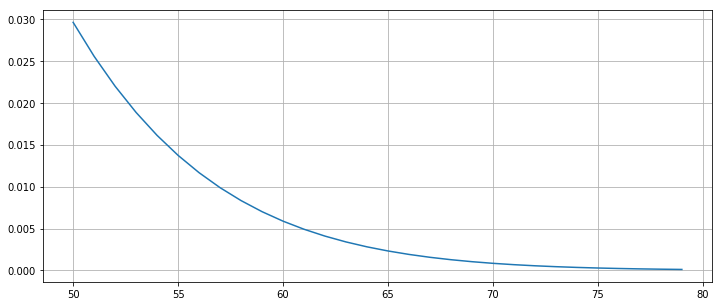

In [92]:
n= np.arange(50,80,1)
rat= []
for i in n:
    b= 1
    for j in range(366-i,366):
        b= j*b/365
    rat.append(b)
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure( figsize= [12,5])
plt.plot( n, rat)
plt.grid()

In [66]:
b/365**20

0.5885616164194201

In [75]:
1/365**100

5.898119322627624e-257

In [76]:
n

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])